In [1]:
using InteractiveIsing, GLMakie, FileIO
using InteractiveIsing.Processes
import InteractiveIsing as II

## Utility functions for experiments

function newmakie(makietype, args...)
    f = makietype(args...)
    scr = GLMakie.Screen()
    display(scr, f)
    f
end

# Weight function variant 1
function weightfunc1(dr,c1,c2)
    prefac = 1
    d = delta(c1,c2)
    dx, dy, dz = d
    # Always positive coupling (ferromagnetic)
    return prefac / norm2(d)
end

function weightfunc_xy_antiferro(dr, c1, c2, ax, ay, az)
    d = delta(c1, c2)
    dx, dy, dz = d  # 先解包
    physical_dr2 = sqrt((ax*dx)^2 + (ay*dy)^2 + (az*dz)^2) 
    # z 方向保持铁磁 (正耦合)
    if dx == 0 && dy == 0
        prefac = 1
    elseif dx == 0
        prefac = 1
    else
        # xy 平面反铁磁 (负耦合)
        prefac = -1
    end
    
    return prefac / physical_dr2
end

function weightfunc_xy_dilog_antiferro(dr, c1, c2)
    d = delta(c1, c2)
    dx, dy, dz = d
    
    if (abs(dx) + abs(dy)) % 2 == 0
        return 1.0 / norm2(d)    # 铁磁
    else
        return -1.0 / norm2(d)   # 反铁磁
    end
    
    return prefac / norm2(d)
end

function weightfunc4(dr,c1,c2)
    prefac = -1
    d = delta(c1,c2)
    dx, dy, _ = d
    # Always positive coupling (ferromagnetic)
    return prefac / norm2(d)
end

##################################################################################
### struct start: TrianglePulseA (simple four-segment triangular waveform)
### Run with TrianlePulseA
###  /\
### /  \    _____
###     \  /
###      \/
struct TrianglePulseA end
function Processes.prepare(::TrianglePulseA, args)
    (;amp, numpulses, rise_point) = args
    steps = num_calls(args)

    first  = LinRange(0, amp, round(Int,rise_point))
    second = LinRange(amp, 0, round(Int,rise_point))
    third  = LinRange(0, -amp, round(Int,rise_point))
    fourth = LinRange(-amp, 0, round(Int,rise_point))
    pulse = vcat(first, second, third, fourth)
    pulse = repeat(pulse, numpulses)

    if steps < length(pulse)
        "Wrong length"
    else
        fix_num = num_calls(args) - length(pulse)
        fix_arr = zeros(Int, fix_num)
        pulse   = vcat(pulse, fix_arr)
    end

    # Predefine storage arrays
    x = Float32[]
    y = Float32[]
    processsizehint!(args, x)
    processsizehint!(args, y)

    return (;pulse, x, y)
end
function (::TrianglePulseA)(args)
    (;pulse, M, x, y, hamiltonian) = args
    pulse_val = pulse[algo_loopidx(args)]
    hamiltonian.b[] = pulse_val
    push!(x, pulse_val)
    push!(y, M[])
end
### struct end: TrianglePulseA
##################################################################################



In [ ]:
xL = 100  # Length in the x-dimension
yL = 100  # Length in the y-dimension
zL = 10   # Length in the z-dimension
g = IsingGraph(xL, yL, zL, stype = Continuous(),periodic = (:x,:y))
# Visual marker size (tune for clarity vs performance)
II.makie_markersize[] = 0.3

# Launch interactive visualization (idle until createProcess(...) later)
interface(g)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\yuhao\.julia\packages\Makie\4JW9B\src\scenes.jl:264
┌ Warning: An algorithm is providing arguments that are already defined in the input arguments: [:g]. 
│  The algorithm arguments will be used.
└ @ InteractiveIsing.Processes d:\Code\Haoranbranch\InteractiveIsing.jl\deps\Processes\src\Trackers\UniqueAlgorithms.jl:75


Estimated time to completion: 0:5:58
Of which remaining: 0:5:58


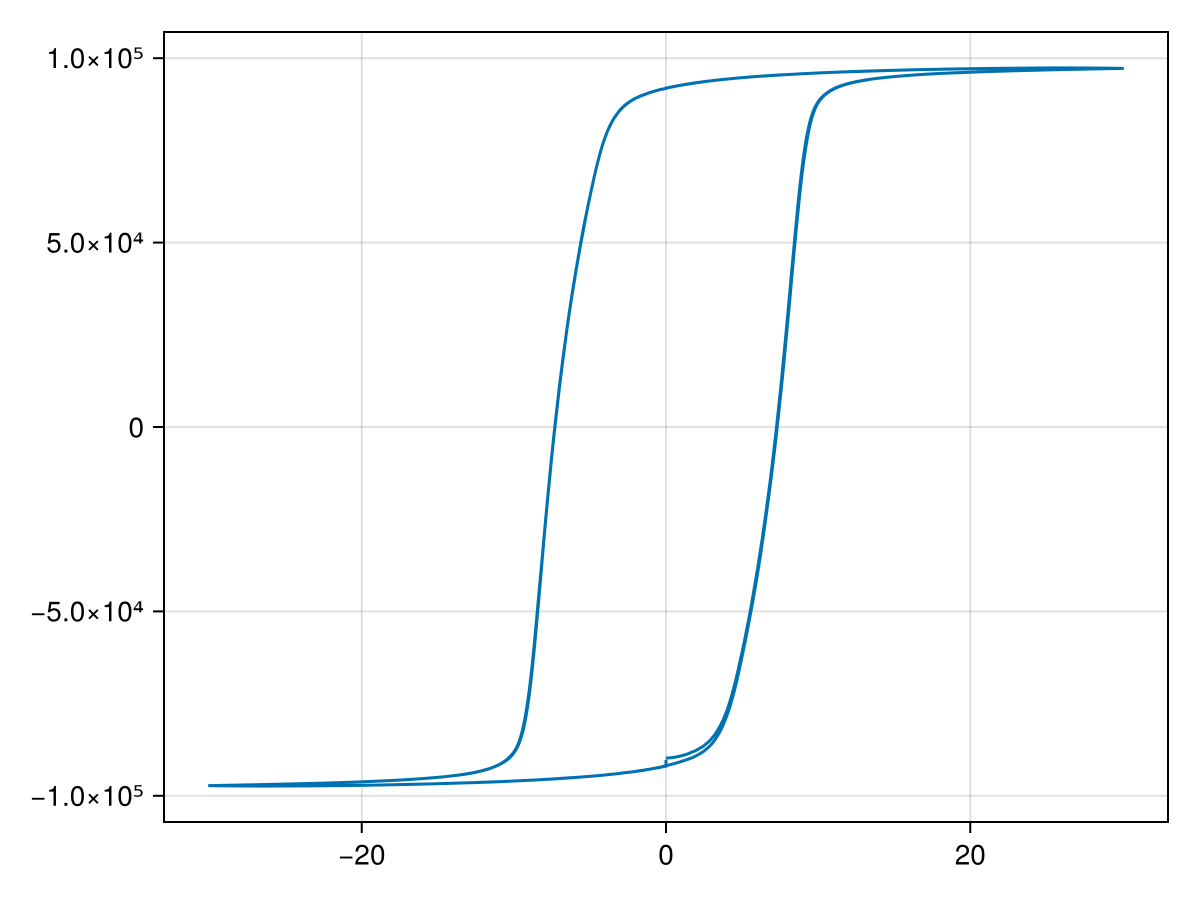

In [ ]:
a1, b1, c1 = -2, 2, 0 
x = range(-1.0, 1.0, length=1000)
y = a1 .* x.^2 .+ b1 .* x.^4 .+ c1 .* x.^6
fig = Figure(size = (800, 400))
ax = Axis(fig[1, 1]; xlabel = "x", ylabel = "f(x)")
lines!(ax, x, y, color = :blue, linewidth = 2)
hlines!(ax, [0], color = (:gray, 0.5), linestyle = :dash)
display(fig)

temp(g,1)


Layer_Dep = 1

g.hamiltonian = Ising(g) + DepolField(g, c=70/(2*Layer_Dep*xL*yL), top_layers=Layer_Dep, bottom_layers=Layer_Dep, zfunc = z -> 0.05/z) + Quartic(g) + Sextic(g)
refresh(g)

# g.hamiltonian = Ising(g) + DepolField(g, c=300, top_layers=1, bottom_layers=1) + Quartic(g) + Sextic(g)

### Use ii. to check if the terms are correct
### Now the H is written like H_self + H_quartic
### Which is Jii*Si^2 + Qc*Jii*Si^4 wichi means Jii=a, Qc*Jii=b in a*Si^2 + b*Si^4

### Set Jii
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)
homogeneousself!(g,a1)
### Set Qc*Jii
g.hamiltonian[4].qc[] = b1/a1
### Set Sc*Jii
g.hamiltonian[5].sc[] = c1/a1



# wg1 = @WG weightfunc_xy_dilog_antiferro NN = (2,2,2)
wg1 = @WG weightfunc1 NN = (1,1,2)
# wg1 = @WG (dr,c1,c2) -> weightfunc_xy_antiferro(dr, c1, c2, 2, 2, 2) NN = (2,2,2)


genAdj!(g[1], wg1)
fullsweep = xL*yL*zL
Time_fctr = 0.5
SpeedRate = Int(Time_fctr*fullsweep)

### risepoint and Amptitude are factors from pulse
risepoint=500
Amptitude =30
# risepoint = round(Int, Amptitude/0.01)


PulseN = 2
Pulsetime = (PulseN * 4 + 10) * risepoint * SpeedRate

compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
inlineplot() do 
    lines(voltage, Pr)
end
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)




# show_connections(g[1],1,1,1)
# visualize_connections(g[1])

In [ ]:
a1, b1, c1 = -2, 2, 0 
x = range(-1.0, 1.0, length=1000)
y = a1 .* x.^2 .+ b1 .* x.^4 .+ c1 .* x.^6
fig = Figure(size = (800, 400))
ax = Axis(fig[1, 1]; xlabel = "x", ylabel = "f(x)")
lines!(ax, x, y, color = :blue, linewidth = 2)
hlines!(ax, [0], color = (:gray, 0.5), linestyle = :dash)
display(fig)

temp(g,1)


Layer_Dep = 1

g.hamiltonian = Ising(g) + DepolField(g, c=80/(2*Layer_Dep*xL*yL), top_layers=Layer_Dep, bottom_layers=Layer_Dep, zfunc = z -> 0.12/z) + Quartic(g) + Sextic(g)
refresh(g)

# g.hamiltonian = Ising(g) + DepolField(g, c=300, top_layers=1, bottom_layers=1) + Quartic(g) + Sextic(g)

### Use ii. to check if the terms are correct
### Now the H is written like H_self + H_quartic
### Which is Jii*Si^2 + Qc*Jii*Si^4 wichi means Jii=a, Qc*Jii=b in a*Si^2 + b*Si^4

### Set Jii
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)
homogeneousself!(g,a1)
### Set Qc*Jii
g.hamiltonian[4].qc[] = b1/a1
### Set Sc*Jii
g.hamiltonian[5].sc[] = c1/a1



# wg1 = @WG weightfunc_xy_dilog_antiferro NN = (2,2,2)
wg1 = @WG weightfunc1 NN = (1,1,2)
# wg1 = @WG (dr,c1,c2) -> weightfunc_xy_antiferro(dr, c1, c2, 2, 2, 2) NN = (2,2,2)


genAdj!(g[1], wg1)
fullsweep = xL*yL*zL
Time_fctr = 0.5
SpeedRate = Int(Time_fctr*fullsweep)

### risepoint and Amptitude are factors from pulse
risepoint=500
Amptitude =30
# risepoint = round(Int, Amptitude/0.01)


PulseN = 2
Pulsetime = (PulseN * 4 + 10) * risepoint * SpeedRate

compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

